## Notebook summary
In this notebook, you will: 
* Preprocess a dataset of movie reviews (The Stanford Sentiment Tree Bank): https://huggingface.co/datasets/sst
* Train a sentiment classifier on the dataset using tensorflow implementations of RNNs
* Use different models and training techniques to improve the performances of the classifier. 

In [ ]:
# imports
from datasets import load_dataset
from pprint import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

## 1. Preprocess and Explore Dataset

### 1.1 Load the dataset

In [ ]:
dataset = load_dataset('sst')
train_set, val_set, test_set = dataset["train"], dataset["validation"], dataset["test"]
print("len train dataset", len(train_set))
print("len val dataset", len(val_set))
print("len test set", len(test_set))

Downloading:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

No config specified, defaulting to: sst/default


Downloading:   0%|          | 0.00/6.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

len train dataset 8544
len val dataset 1101
len test set 2210


This create a `Dataset` object (a kind of list of dictionnaries), for which you can iterate on samples like an Numpy Array.

In [ ]:
print(train_set.column_names)
for k,v in train_set[0].items():
  print(k,v)

['sentence', 'label', 'tokens', 'tree']
sentence The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
label 0.6944400072097778
tokens The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.
tree 70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0


### 1.2 Binarize labels

In [ ]:
def binarize_label(example):
  label = example['label']
  if label > 0.6:
    example["binary_label"] = 1 # positive label
  elif label < 0.4:
    example["binary_label"] = 0 # negative label. 
  else: 
    example["binary_label"] = 2 # neutral labels. 
  return example

In [ ]:
def get_binary_labels(dataset):
  processed_dataset = dataset.map(binarize_label)
  return processed_dataset

In [ ]:
train_set = get_binary_labels(train_set)
val_set = get_binary_labels(val_set)
test_set = get_binary_labels(val_set)

  0%|          | 0/8544 [00:00<?, ?ex/s]

  0%|          | 0/1101 [00:00<?, ?ex/s]

  0%|          | 0/1101 [00:00<?, ?ex/s]

**Exercise 1**:  
1. Create a function `visualize_labels` that visualizes labels distribution using `plt.hist`
2. Create a function `select_sequence_from_label` that samples movie reviews with a specific label value

In [ ]:
def visualize_labels(dataset):
  plt.hist(dataset['label'], 20, density=True, facecolor='g', alpha=0.75)

In [ ]:
def select_sequence_from_label(dataset, label, num_samples=5, epsilon=0.025):
  # label - epsilon -> label + epsilon
  dataset_with_label = dataset.filter(lambda example: label - epsilon <= example['label']<= label+epsilon)
  print("samples from label:", label)
  pprint(dataset_with_label["sentence"][0:num_samples], compact=True)

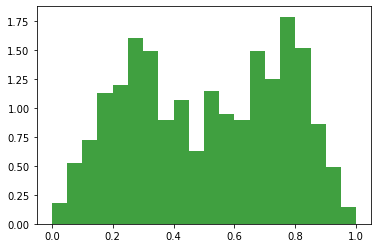

In [ ]:
visualize_labels(train_set)

In [ ]:
select_sequence_from_label(train_set, 0.9, num_samples=5, epsilon=0.025)

  0%|          | 0/9 [00:00<?, ?ba/s]

samples from label: 0.9
['Just the labour involved in creating the layered richness of the imagery in '
 'this chiaroscuro of madness and light is astonishing .',
 'Good fun , good action , good acting , good dialogue , good pace , good '
 'cinematography .',
 'Grenier is terrific , bringing an unforced , rapid-fire delivery to Toback '
 "'s Heidegger - and Nietzsche-referencing dialogue .",
 'The wanton slipperiness of \\* Corpus and its amiable jerking and reshaping '
 'of physical time and space would make it a great piece to watch with kids '
 'and use to introduce video as art .',
 'I walked away from this new version of E.T. just as I hoped I would -- with '
 'moist eyes .']


### 1.1 Text Cleaning
**Exercise 2**: 
Create a function `tokenize_sentence` that cleans and tokenize the "tokens" column, as follows: 

In [ ]:
def tokenize(dataset):
  def tokenize_sentence(example):
    # all letters in lower case and tokenize
    example["tokens"] = example["tokens"].lower().split("|")
    # remove punctuation.
    example["tokens"] = [w for w in example["tokens"] if w.isalpha()]
    return example
  processed_dataset = dataset.map(tokenize_sentence)
  return processed_dataset

### 1.2 Build Vocabulary

**Exercise 3:**   
Create a function `build_vocab` that manually creates the vocabulary from the dataset. 

In [ ]:
def build_vocab(dataset, min_token_count=1, special_tokens={"<PAD>": 0, "<UNK>": 1}):
  token_to_count = {}
  for seq_tokens in dataset["tokens"]:
    for token in seq_tokens:
      if token not in token_to_count:
        token_to_count[token] = 0
      token_to_count[token] += 1

  token_to_idx = {}
  for token, idx in special_tokens.items():
    token_to_idx[token] = idx
  for token, count in sorted(token_to_count.items()):
    if count >= min_token_count:
      token_to_idx[token] = len(token_to_idx)
  return token_to_idx, token_to_count

The vocabulary is built upon the full dataset (to take in account all words). 
The next code block load the full dataset and build the vocabulary over the dataset.

In [ ]:
train_val_set = load_dataset("sst", split='train+validation+test')
train_val_set = tokenize(train_val_set)
print(train_val_set[0])
vocab, tokens_to_count = build_vocab(train_val_set)
print("number of words in vocab", len(vocab))

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-cf3b74f74291112a.arrow


{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 0.6944400072097778, 'tokens': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'van', 'damme', 'or', 'steven', 'segal'], 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
number of words in vocab 17090


In [ ]:
all_tokens = train_val_set["tokens"]

### 1.5 Visualize most common words
**Exercise 4**: Visualize the 50 most common words of the full dataset (except stop words). 

In [ ]:
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def plot_common_words(all_tokens, remove_stop_words=True):
  if remove_stop_words:
    stop_words = stopwords.words('english')
    flattened_tokens = [w for sent in all_tokens for w in sent if w not in set(stop_words)]
  else:
    flattened_tokens = [w for sent in all_tokens for w in sent]
  # histogram of most common words. 
  fdist = FreqDist(flattened_tokens)
  print(fdist.items())
  fdist1 = fdist.most_common(50)
  fdist1_dict = {key: value for key, value in fdist1}
  fig, ax = plt.subplots(1, 1, figsize=(60, 10))
  ax.set_title("Most common words", fontsize=24)
  ax.bar(fdist1_dict.keys(), fdist1_dict.values())
      # ax.xticks(rotation=45)
  ax.tick_params(axis='x', labelsize=24, labelrotation=45)
  rects = ax.patches
  labels = [rect.get_height() for rect in rects]
  for rect, label in zip(rects, labels):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
                  ha='center', va='bottom', fontsize=20)
  ax.legend()

No handles with labels found to put in legend.


dict_items([('rock', 34), ('destined', 8), ('century', 18), ('new', 206), ('conan', 2), ('going', 86), ('make', 278), ('splash', 5), ('even', 382), ('greater', 7), ('arnold', 15), ('schwarzenegger', 8), ('van', 12), ('damme', 2), ('steven', 24), ('segal', 1), ('gorgeously', 6), ('elaborate', 10), ('continuation', 2), ('lord', 5), ('rings', 7), ('trilogy', 4), ('huge', 20), ('column', 2), ('words', 27), ('adequately', 4), ('describe', 8), ('peter', 20), ('jackson', 25), ('expanded', 4), ('vision', 32), ('tolkien', 3), ('bryan', 2), ('adams', 9), ('contributes', 1), ('slew', 1), ('songs', 16), ('potential', 27), ('hits', 22), ('simply', 72), ('intrusive', 1), ('story', 493), ('whole', 79), ('package', 4), ('certainly', 55), ('captures', 30), ('intended', 19), ('er', 3), ('spirit', 46), ('piece', 84), ('think', 89), ('america', 29), ('would', 246), ('enough', 267), ('plucky', 2), ('british', 22), ('eccentrics', 2), ('hearts', 13), ('gold', 4), ('yet', 125), ('act', 34), ('still', 179), ('

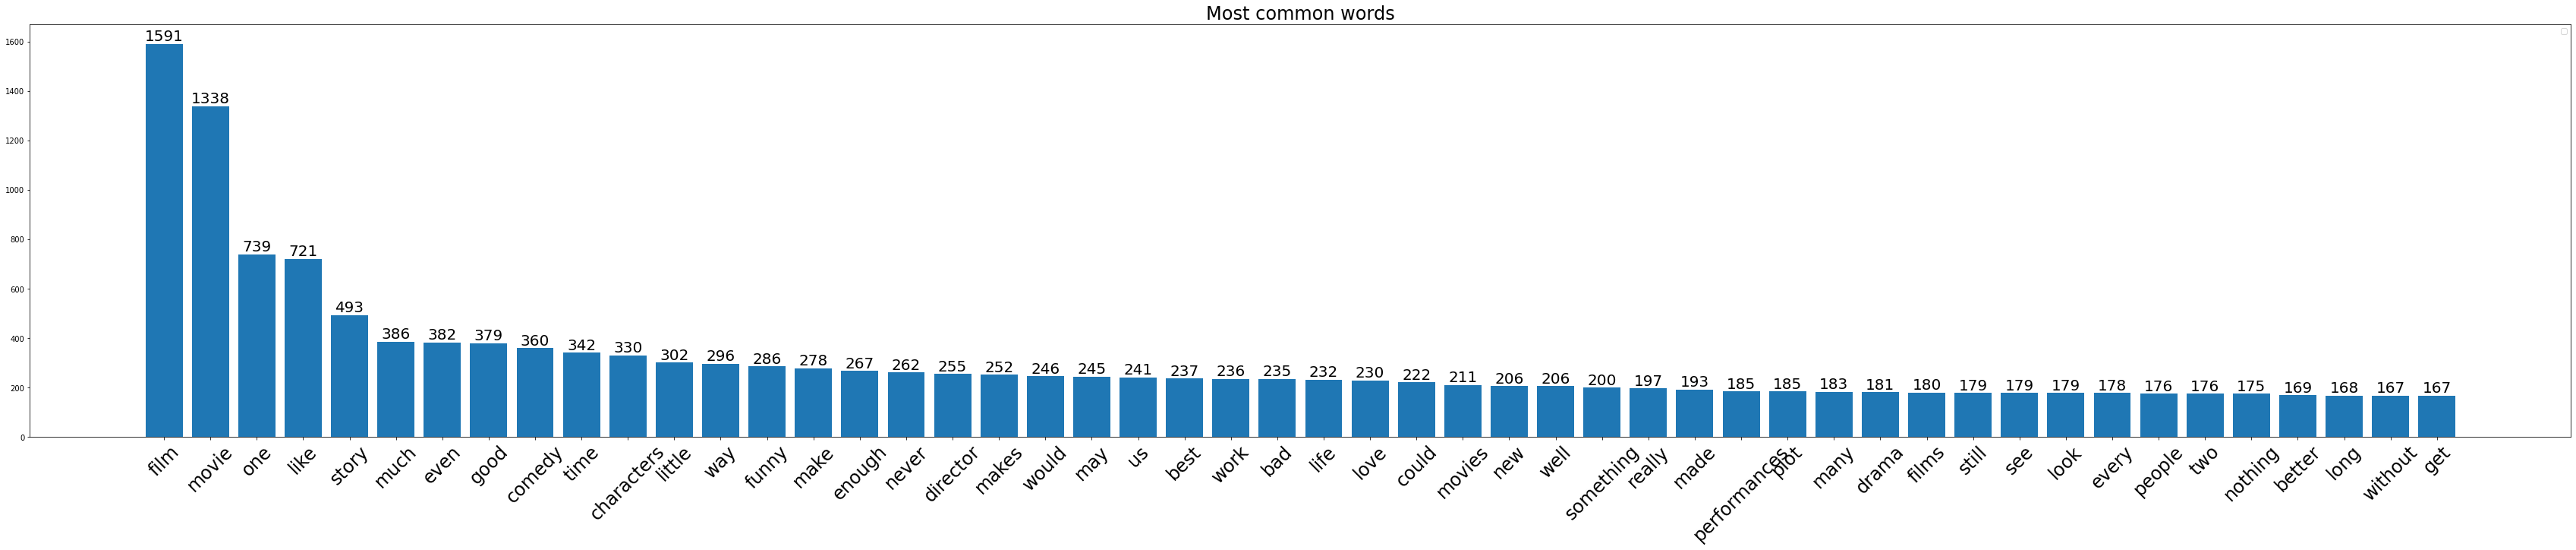

In [ ]:
plot_common_words(all_tokens, remove_stop_words=True)

### 1.6 Encode sentences
The next code block creates an `encode` function that convert a sequence of tokens into integers using the vocabulary. 

In [ ]:
def encode(seq_tokens, vocab, allow_unk=True):
  seq_idx = []
  for token in seq_tokens:
    if token not in vocab:
      if allow_unk:
        token = '<UNK>'
      else:
        raise KeyError('Token "%s" not in vocab' % token) 
    seq_idx.append(vocab[token])
  return seq_idx

**Exercise 5:**
Use `tensorflow.keras.preprocessing.text.Tokenizer` (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to implement more simply:
1. The construction of the vocabulary using the method `fit_on_texts`
2. The `encode` function using the method `texts_to_sequences
`

In [ ]:
# prepare tokenizer
docs = [" ".join(sent) for sent in all_tokens]
t = Tokenizer() # use to build a vocabulary
t.fit_on_texts(docs) # build the vocabulary. 
vocab_size = len(t.word_index) + 1 # for the padding token.
vocab = t.word_index
print("LEN VOCAB:", len(vocab))
vocab["<PAD>"] = 0

LEN VOCAB: 17088


In [ ]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(len(encoded_docs))
print(encoded_docs[0])

11855
[1, 579, 6, 2451, 5, 20, 1, 1138, 93, 6741, 3, 8, 61, 237, 5, 68, 2, 3664, 51, 2752, 32, 1375, 2452, 1697, 6742, 39, 854, 9496]


The next code block processes the dataset by: 
* Encoding each sentence into integers and adding padding. 
* Categorize labels into three categories (positive, negative, neutral). 
* Create a tensorflow dataset with encoded sentence (=input data) and category label (=target)

In [ ]:
# get max sequence length
max_len = max([len(sent) for sent in all_tokens])
print("max sentence length", max_len)

max sentence length 51


In [ ]:
def process_dataset(dataset, vocab, max_len):
  def process_example(example):
    example["inputs"] = encode(example['tokens'], vocab, allow_unk=False)
    example = binarize_label(example)
    return example
  dataset = tokenize(dataset)
  encoded_dataset = dataset.map(process_example)
  print("encoded_dataset[0]")
  pprint(encoded_dataset[0], compact=True)
  # pad sequences
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset["inputs"], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
  print(padded_sequences.shape)
  tfdataset = tf.data.Dataset.from_tensor_slices(
                (padded_sequences, encoded_dataset["binary_label"]))
  return tfdataset

In [ ]:
train_dataset = process_dataset(train_set, vocab, max_len)
val_dataset = process_dataset(val_set, vocab, max_len)
test_dataset = process_dataset(test_set, vocab, max_len)

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow


  0%|          | 0/8544 [00:00<?, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [1, 579, 6, 2451, 5, 20, 1, 1138, 93, 6741, 3, 8, 61, 237, 5, 68, 2,
            3664, 51, 2752, 32, 1375, 2452, 1697, 6742, 39, 854, 9496],
 'label': 0.6944400072097778,
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century',
            'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a',
            'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger',
            'van', 'damme', 'or', 'steven', 'segal'],
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
(8544, 51)


  0%|          | 0/1101 [00:00<?, ?ex/s]

  0%|          | 0/1101 [00:00<?, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [7, 2, 690, 12, 13, 690, 104, 23, 1336, 3, 14968],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 51)


  0%|          | 0/1101 [00:00<?, ?ex/s]

  0%|          | 0/1101 [00:00<?, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [7, 2, 690, 12, 13, 690, 104, 23, 1336, 3, 14968],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 51)


In [ ]:
# Create dataloader using batch. 
batch_size = 32
train_dataloader = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(train_dataloader))
val_dataloader = val_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(val_dataloader))
test_dataloader = test_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(test_dataloader))

(<tf.Tensor: shape=(32, 51), dtype=int32, numpy=
 array([[   7,    2,  690, ...,    0,    0,    0],
        [  55,   24,  311, ...,    0,    0,    0],
        [   3,   38,   19, ...,    0,    0,    0],
        ...,
        [   2, 4213,  617, ...,    0,    0,    0],
        [  22,   62,    6, ...,    0,    0,    0],
        [   9,    2,   64, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)

## 2. Build RNN Model

In [ ]:
# Build Model
def build_LSTM(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  inputs = tf.keras.Input(shape=(seq_len,))
  # Embedding Layer
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(inputs) # PADDING IS NOT ACCOUNTED IN LOSS. 
  # LSTM Layer
  hidden = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)(embedding) # return last hidden state by default. 
  outputs = tf.keras.layers.Dropout(rate=dropout_rate)(hidden)
  # Dense Layer - projection over the output size (i.e number of classes.)
  outputs = tf.keras.layers.Dense(output_size)(outputs)
  lstm_model = tf.keras.Model(outputs=outputs, inputs=inputs, name='lstm_for_classification')
  return lstm_model

**Exercise 6:**
Implement the same model using `tensorflow.keras.Sequential` API instead: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [ ]:
# define model
def build_LSTM_2(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential()
  e = Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)
  model.add(e)
  lstm = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)
  model.add(lstm)
  model.add(Dense(output_size, activation='softmax')) # we compute only logits. 
  return model

## 3. Train the sentiment classifier
**Exercise 6**:  
Create a `train_LSTM` function that trains the lstm model on the train dataset. 
See the following tutorial as an example: https://www.tensorflow.org/guide/keras/train_and_evaluate


In [ ]:
lstm_model = build_LSTM_2(seq_len=max_len, vocab_size=len(vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
EPOCHS = 10

In [ ]:
def train_LSTM(model, optimizer, EPOCHS, train_dataset, val_dataset, checkpoint_path):
    # save checkpoints and create callbacks
    LSTM_ckpt_path = checkpoint_path + '/' + 'LSTM-{epoch}'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=LSTM_ckpt_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)
    ]
    # compile model with optimizer and loss, metrics = "accuracy": 
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"]) 

    print(model.summary())

    # --- starting the training ... -----------------------------------------------
    start_training = time.time()
    # fit the model to the train dataset:
    rnn_history = model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=val_dataset,
                            callbacks=callbacks,
                            verbose=2)
    print('Training time for {} epochs: {}'.format(EPOCHS, time.time() - start_training))
    print('training of a RNN for sentiment analysis done...')
    return rnn_history

In [ ]:
import os
import time
checkpoint_path = "/checkpoints"
if not os.path.isdir(checkpoint_path):
  os.makedirs(checkpoint_path)

In [ ]:
train_history = train_LSTM(model=lstm_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=train_dataloader, val_dataset=val_dataloader, checkpoint_path=checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 51, 32)            546848    
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 571,875
Trainable params: 571,875
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.93870, saving model to /checkpoints/LSTM-1
267/267 - 61s - loss: 0.4760 - accuracy: 0.8287 - val_loss: 0.9387 - val_accuracy: 0.5919 - 61s/epoch - 228ms/step
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.93870
267/267 - 10s - loss: 0.4597 

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

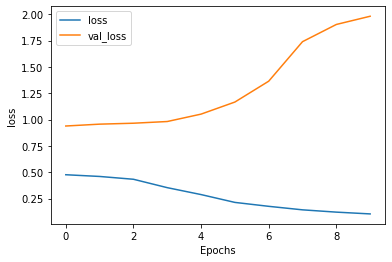

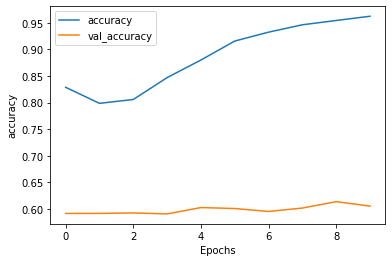

In [ ]:
plot_graphs(train_history, "loss")
plot_graphs(train_history, "accuracy")

## 4. Predictions on test dataset

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_dataloader)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

69/69 [==============================] - 1s 13ms/step - loss: 1.8708 - accuracy: 0.6091
Test Loss: 1.870819330215454
Test Accuracy: 0.6091485619544983


In [ ]:
#predict on a sample text without padding.
sample_text = 'The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.'
sample_tokens = sample_text.lower().split()
sample_tokens = [w for w in sample_tokens if w.isalpha()]
sample_text_encoded = encode(sample_tokens, vocab)
sample_text_encoded = tf.keras.preprocessing.sequence.pad_sequences([sample_text_encoded], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
print(sample_text_encoded)

[[   1   16   86   22    1  503    3    1 7968  177   36   79   22  929
    14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]]


In [ ]:
sample_text_encoded = tf.constant(sample_text_encoded, dtype=tf.int32)
predictions = lstm_model.predict(sample_text_encoded)
predictions_probs = tf.nn.softmax(predictions)
print(predictions_probs)
predicted_label  = tf.argmax(predictions_probs, axis=-1)
print("predicted label {} with probs {}".format(predicted_label, tf.squeeze(predictions_probs)[tf.squeeze(predicted_label).numpy()]))

tf.Tensor([[9.8652136e-01 1.3473485e-02 5.1702732e-06]], shape=(1, 3), dtype=float32)
predicted label [0] with probs 0.9865213632583618


### Additionnal Exercises. 
Recode Implementation with instead: 
   - several layers of LSTM
   - bi-directionnal LSTM using https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
   - average of hidden states as final hidden representation (instead of last hidden state). 
   - add gradient clipping: https://www.tensorflow.org/api_docs/python/tf/clip_by_norm
   - do hyperparameter-search on model dimensions, training hyper-parameters to reach a better val accuracy. 